# Notebook for the audio feature of the dualsenseo controller.

## 1 Mic limitation

by using the externel device play the audio from 20hz to 22000hz, then plot the frequency of the mic detection

In [82]:
import numpy as np
import pyaudio
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

def list_microphones():
    pa = pyaudio.PyAudio()
    print("Available Microphone Devices:\n")
    
    for i in range(pa.get_device_count()):
        device_info = pa.get_device_info_by_index(i)
        if device_info['maxInputChannels'] > 0:
            print(f"Device Index: {i}")
            print(f"  Name: {device_info['name']}")
            print(f"  Channels: {device_info['maxInputChannels']}")
            print(f"  Default Sample Rate: {device_info['defaultSampleRate']}")
            print(f"  Is Default Input Device: {'Yes' if i == pa.get_default_input_device_info()['index'] else 'No'}")
            print("-" * 30)
    
    pa.terminate()

def get_device_channels(device_index):
    pa = pyaudio.PyAudio()
    device_info = pa.get_device_info_by_index(device_index)
    pa.terminate()
    return device_info['maxInputChannels']

def capture_and_visualize(device_index=0, duration=10):
    # Get the actual number of channels for the device
    channels = 1
    
    # Parameters
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    RATE = 44100
    
    # Initialize PyAudio
    pa = pyaudio.PyAudio()
    
    try:
        # Open the selected audio input stream
        stream = pa.open(format=FORMAT,
                        channels=channels,
                        rate=RATE,
                        input=True,
                        input_device_index=device_index,
                        frames_per_buffer=CHUNK)
        
        print(f"Recording for {duration} seconds from device index {device_index} with {channels} channels...")
        
        # Collect audio data
        frames = []
        for _ in range(0, int(RATE / CHUNK * duration)):
            try:
                data = stream.read(CHUNK)
                frames.append(np.frombuffer(data, dtype=np.int16))
            except Exception as e:
                print(f"Error reading stream: {e}")
                break
        
        # Close the stream
        stream.stop_stream()
        stream.close()
        
        # Combine frames into a single numpy array
        audio_data = np.concatenate(frames)
        
        # Reshape based on number of channels
        if channels > 1:
            audio_data = audio_data.reshape(-1, channels)
            print(f"Audio input has {channels} channels. Analyzing channel 1 only.")
            channel_data = audio_data[:, 0]
        else:
            channel_data = audio_data
        
        # Time domain visualization
        plt.figure(figsize=(14, 8))
        plt.subplot(3, 1, 1)
        time_axis = np.linspace(0, len(channel_data) / RATE, num=len(channel_data))
        plt.plot(time_axis, channel_data, color='blue')
        plt.title("Sound Wave (Channel 1)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        
        # Frequency domain visualization
        fft_data = fft(channel_data)
        fft_magnitude = np.abs(fft_data)[:len(fft_data)//2]
        freqs = fftfreq(len(channel_data), 1 / RATE)[:len(fft_data)//2]
        
        plt.subplot(3, 1, 2)
        plt.plot(freqs, fft_magnitude, color='red')
        plt.title("Frequency Spectrum (FFT - Channel 1)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        
        # Calculate average frequency
        avg_frequency = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
        print(f"Average Frequency (Channel 1): {avg_frequency:.2f} Hz")
        
        # Dominant frequency visualization
        dominant_freq = freqs[np.argmax(fft_magnitude)]
        plt.subplot(3, 1, 3)
        plt.plot(freqs, fft_magnitude, color='green')
        plt.axvline(x=dominant_freq, color='red', linestyle='--')
        plt.title("Dominant Frequency (Channel 1)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.text(dominant_freq, max(fft_magnitude), f'{dominant_freq:.2f} Hz', color='red')
        
        plt.tight_layout()
        plt.show()
        
        return avg_frequency, dominant_freq
    
    finally:
        pa.terminate()







In [77]:
list_microphones()

Available Microphone Devices:

Device Index: 1
  Name: DualSense Wireless Controller
  Channels: 2
  Default Sample Rate: 48000.0
  Is Default Input Device: No
------------------------------
Device Index: 2
  Name: MacBook Air Microphone
  Channels: 1
  Default Sample Rate: 48000.0
  Is Default Input Device: Yes
------------------------------
Device Index: 4
  Name: Wayne iPhone Microphone
  Channels: 1
  Default Sample Rate: 48000.0
  Is Default Input Device: No
------------------------------


Recording for 20 seconds from device index 2 with 1 channels...
Average Frequency (Channel 1): 5041.79 Hz


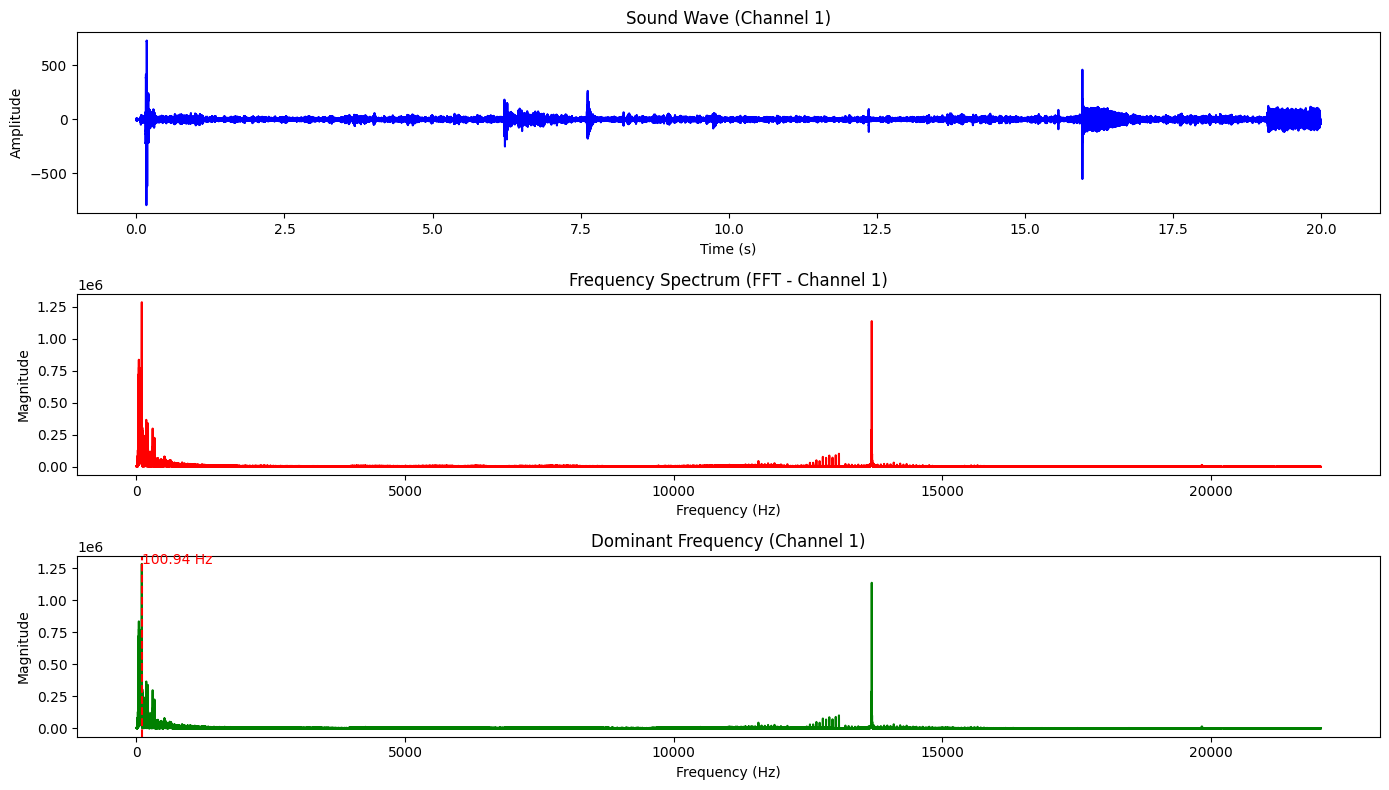

(np.float64(5041.785362804034), np.float64(100.93845274390243))

In [84]:
# play 19000hz 5s on the devcie of the macbook air m3 device 
capture_and_visualize(device_index=2, duration=20)


Recording for 5 seconds from device index 1 with 1 channels...
Average Frequency (Channel 1): 5679.52 Hz


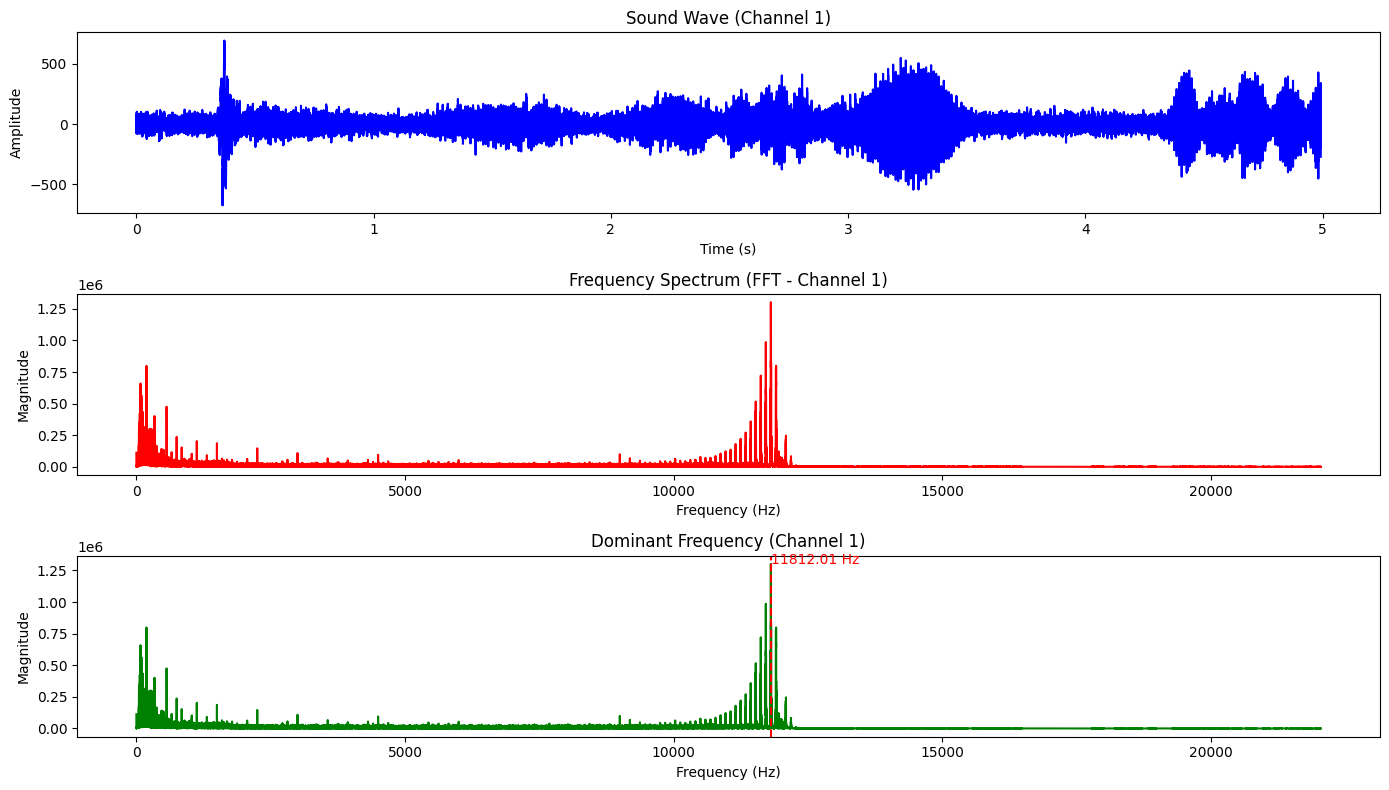

(np.float64(5679.515908136321), np.float64(11812.013535610466))

In [85]:
# play 11900hz max on the devcie of the controller
capture_and_visualize(device_index=1, duration=5)

Recording for 20 seconds from device index 1 with 1 channels...
Average Frequency (Channel 1): 3871.58 Hz


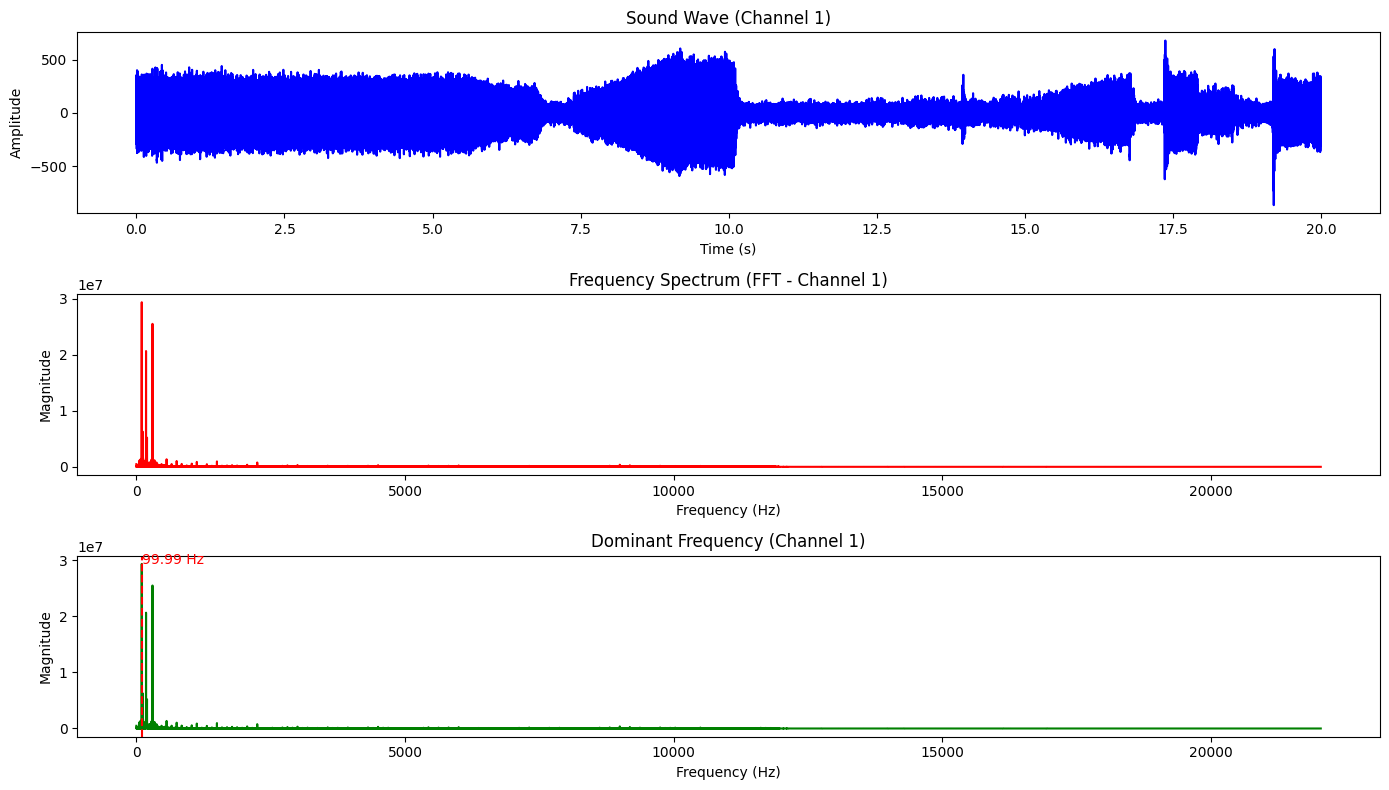

(np.float64(3871.5834807109304), np.float64(99.9880907012195))

In [86]:
# play the sound from 100 to 50 , the minumun of the device is 100hz can be detect 
capture_and_visualize(device_index=1, duration=20)

Result : Frequency limiation of the controlelr 100hz to 11800hz 

## 2 Speaker Limitation